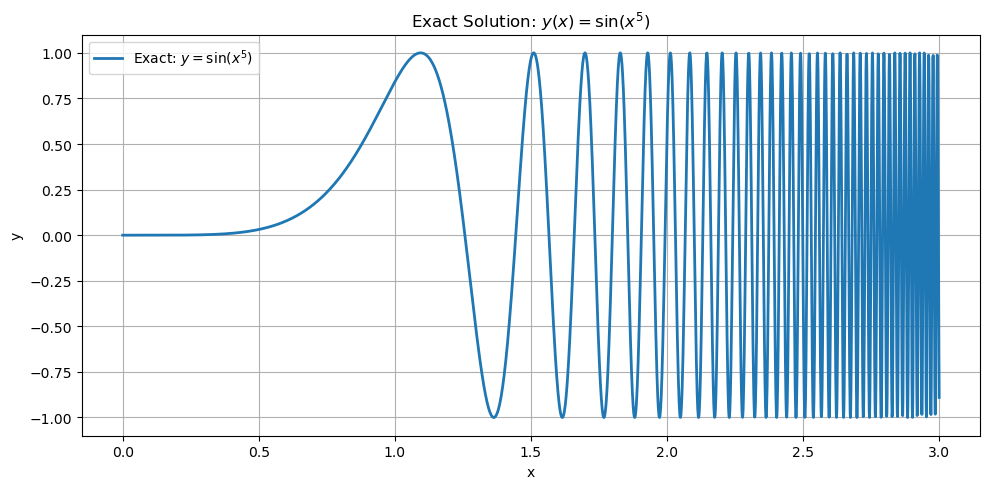

In [16]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

x = jnp.linspace(0, 3, 3000)

# exact y = sin(x^6)
y = jnp.sin(x**5)

plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Exact: $y=\\sin(x^5)$', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Exact Solution: $y(x) = \\sin(x^5)$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Uniform domain decomposition
n_sub = 2

In [17]:
import os
import sys
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Optional: Add project root to PYTHONPATH if needed
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from utils.data_utils import generate_subdomains, generate_collocation_points
from utils.window_function import my_window_func
from utils.window_function import my_precise_window_func
from model.fbpinn_model import FBPINN
from train.trainer_fbpinn import train_fbpinn
from physics.problems import SineX5ODE as pde_module

problem = pde_module()  # 实例化，绑定self
pde_residual_loss = problem.residual  
u_exact = problem.exact
ansatz = problem.ansatz
domain = problem.domain

# Training hyperparameters
steps = 50000
lr = 1e-3
n_sub = 4
overlap = 0.1
n_points_per_subdomain = 1000 # All together 1000

mlp_config = {
    "in_size": 1,
    "out_size": 1,
    "width_size": 32,
    "depth": 2,
    "activation": jax.nn.tanh,
}

left, right = pde_module.domain  # 此时 left=0, right=3
domain = (jnp.array([left]), jnp.array([right]))        # 变为 [[0, 3]]
print(domain)


(Array([0], dtype=int32), Array([3], dtype=int32))


In [4]:
subdomains_list = generate_subdomains(domain, n_sub, overlap)
print(subdomains_list)

centers [0. 1. 2. 3.]
[(Array([-0.55], dtype=float32), Array([0.55], dtype=float32)), (Array([0.45], dtype=float32), Array([1.55], dtype=float32)), (Array([1.45], dtype=float32), Array([2.55], dtype=float32)), (Array([2.45], dtype=float32), Array([3.55], dtype=float32))]


[[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 2.2994269e-09 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.5186519e-09 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0030250e-09 1.0000000e+00]]


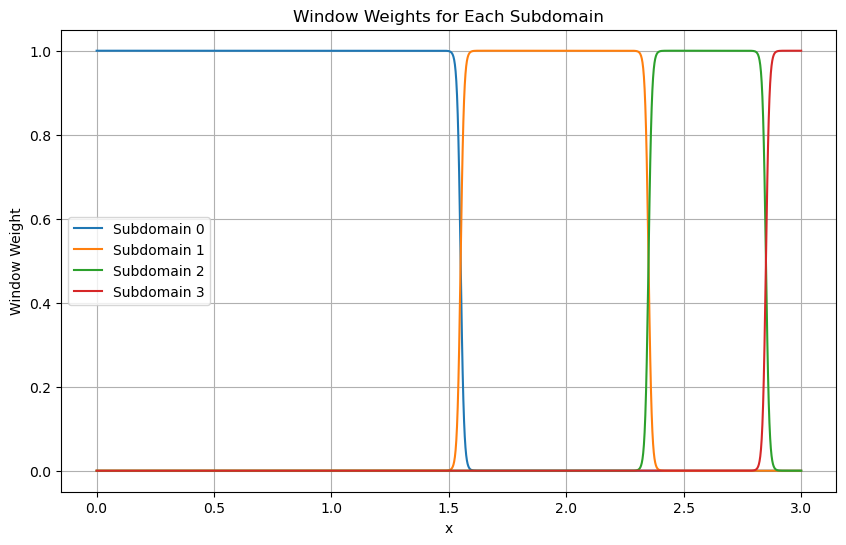

In [ ]:
# illustration of window function
x_test =  jnp.linspace(0, 1, 600).reshape(-1, 1) 
window_weights_1 = my_window_func(subdomains_list, n_sub, x_test, tol=1e-8)
# plot
plt.figure(figsize=(10, 6))
for i in range(window_weights_1.shape[1]):
    plt.plot(x_test, window_weights_1[:, i], label=f"Subdomain {i}")
plt.xlabel('x')
plt.ylabel('Window Weight')
plt.legend()
plt.title('Window Weights for Each Subdomain')
plt.grid(True)
plt.show()

In [19]:
key = jax.random.PRNGKey(42)
model_1 = FBPINN(
    key=key,
    num_subdomains=n_sub,
    ansatz=ansatz,
    subdomains=subdomains_list,  
    mlp_config=mlp_config
)
subdomain_collocation_points_uniform, global_collocation_points_uniform = generate_collocation_points(
domain=domain,
subdomains_list=subdomains_list,
n_points_per_subdomain=n_points_per_subdomain,
seed=0
)
print(subdomain_collocation_points_uniform)

TypeError: __init__() got an unexpected keyword argument 'num_subdomains'

In [15]:
# test
x_test = jnp.linspace(domain[0], domain[1], 1000)
# train
model_1, loss_hist, (t_steps, t_l1) = train_fbpinn(
    model=model_1,
    subdomain_collocation_points=subdomain_collocation_points_uniform,
    steps=steps,
    lr=lr,
    pde_residual_loss=pde_residual_loss,
    x_test=x_test,
    u_exact=u_exact,
    save_dir=None,
    checkpoint_every=0
)


FBPINN: 100%|██████████| 50000/50000 [08:12<00:00, 101.54it/s, l1=1.59e-01, loss=1.13e+04]


In [18]:
# Plot
u_pred_uniform = jax.vmap(model_1)(x_test).squeeze()
u_true = u_exact(x_test)

In [7]:
def plot_fbpinn_summary(x_test, u_true, u_pred,
                        train_loss, test_steps, test_l1,
                        model):
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    axs = axs.flatten()

    # 1. Prediction vs Exact
    axs[0].plot(x_test, u_pred, label="Predicted")
    axs[0].plot(x_test, u_true, "--", label="Exact")
    axs[0].set_title("Prediction vs Exact")
    axs[0].legend()
    axs[0].grid(True)

    # 2. Training loss
    axs[1].plot(train_loss, label="Train Loss")
    axs[1].set_title("Training Loss (Log Scale)")
    axs[1].set_yscale("log")
    axs[1].legend()
    axs[1].grid(True)

    # 3. L1 error curve
    axs[2].plot(test_steps, test_l1, label="L1 Error")
    axs[2].set_title("Test L1 Error Curve")
    axs[2].set_yscale("log")
    axs[2].set_xlabel("Step")
    axs[2].set_ylabel("L1")
    axs[2].legend()
    axs[2].grid(True)

    # 4. Subdomain partial predictions
    n_sub = len(model.subnets)
    for i in range(n_sub):
        # 1) 得到子域网络输出 (net_i(x))
        partial_solution_i = jax.vmap(lambda x: model.subdomain_pred(i, x))(x_test).squeeze()
        # 2) 得到窗口函数 (W_i(x))
        window_i = model.subdomain_window(i, x_test).squeeze()
        # 3) 得到真正的子域局部解: W_i(x) * net_i(x)
        partial_weighted = partial_solution_i * window_i
        
        # 如果你想对每个子域单独加边界条件，并且 ansatz 正好就是“子域级别”的，可以在这里写：
        # partial_ansatz_i = jax.vmap(lambda xi, p: model.ansatz(xi, p))(x_test, partial_weighted)
        # axs[3].plot(x_test, partial_ansatz_i, label=f"Subdomain {i}", alpha=0.6)
        
        # 否则，直接画部分解即可
        axs[3].plot(x_test, partial_weighted, label=f"Subdomain {i}", alpha=0.6)

    # 画 exact
    axs[3].plot(x_test, u_true, "--", color="black", label="Exact", linewidth=2)
    axs[3].set_title("Subdomain Partial Predictions")
    axs[3].legend(fontsize=8, ncol=2)
    axs[3].grid(True)

    plt.tight_layout()
    plt.show()


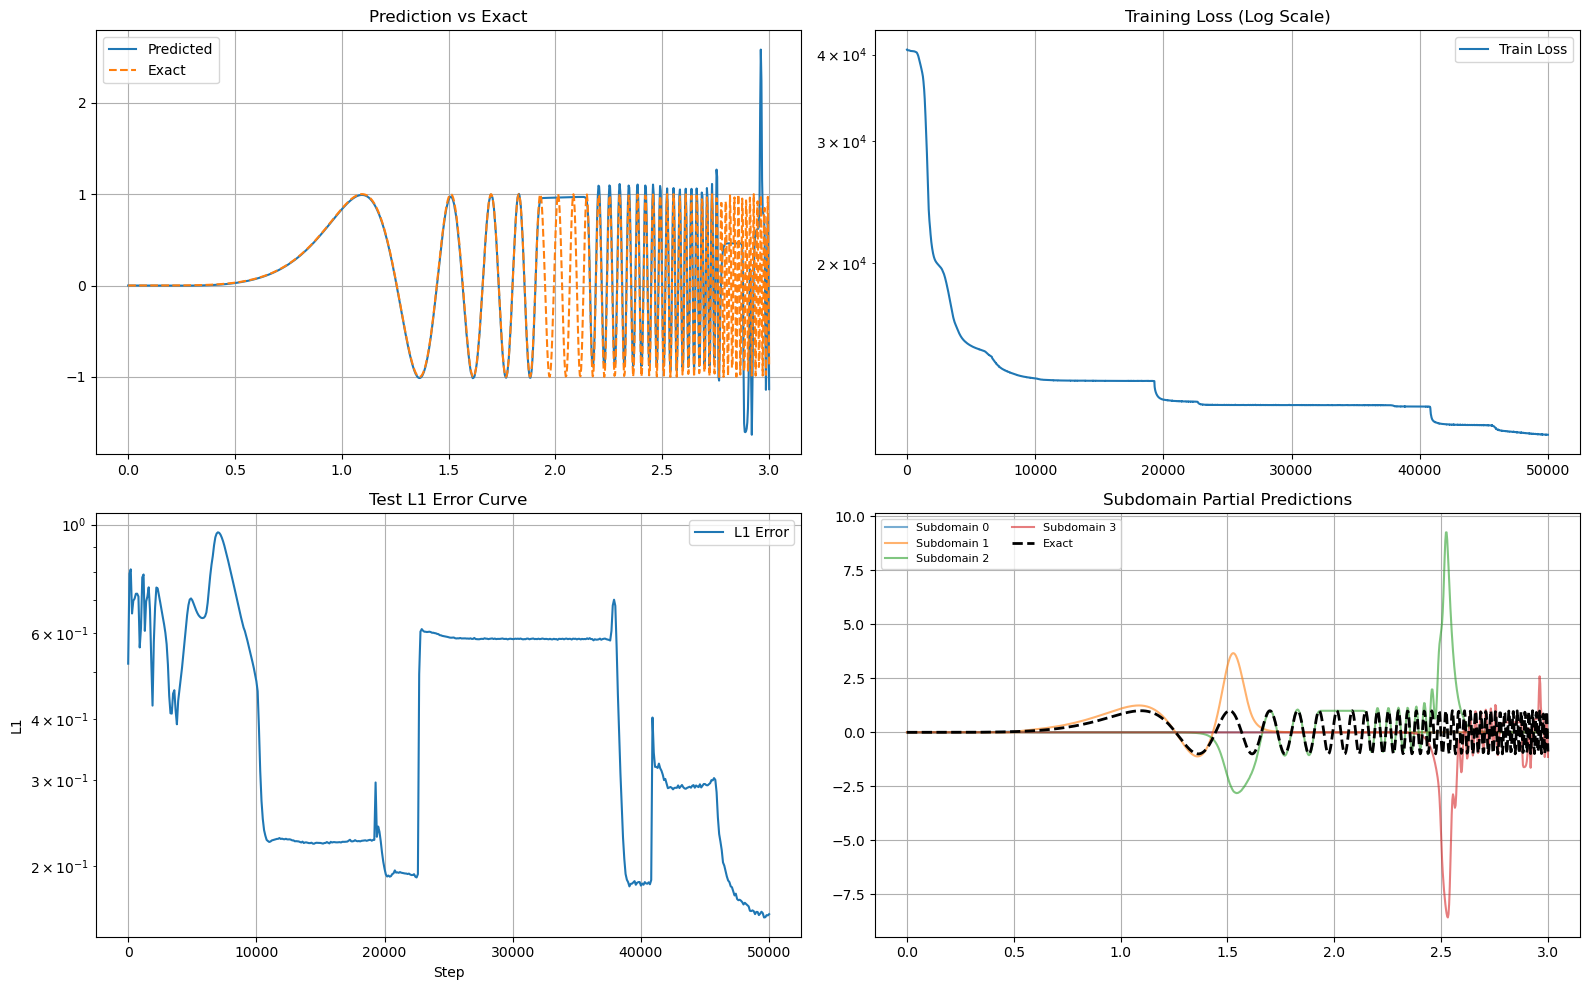

In [20]:
plot_fbpinn_summary(
    x_test=x_test,
    u_true=u_true,
    u_pred=u_pred_uniform,
    train_loss=loss_hist,
    test_steps=t_steps,
    test_l1=t_l1,
    model=model_1
)


### Not uniform
n_sub = 2

In [ ]:
# 整体域 [0, 3]
domain_1d_custom = (jnp.array([0.0]), jnp.array([3.0]))
transition = overlap
# 手动给出 4 个子域；长度各不相同，但相邻子域交叠区恰为 0.5

subdomains_custom = [
    (jnp.array([-1.6]), jnp.array([1.6])),
    (jnp.array([1.5]), jnp.array([2.4])),
    (jnp.array([2.3]), jnp.array([2.9])),
    (jnp.array([2.8]), jnp.array([3.2])),
]
x_plot = jnp.linspace(domain_1d_custom[0][0], domain_1d_custom[1][0], 1000).reshape(-1, 1)
xmins = jnp.stack([s[0] for s in subdomains_custom])
xmaxs = jnp.stack([s[1] for s in subdomains_custom])
wmins = jnp.full_like(xmins, transition)
wmaxs = jnp.full_like(xmaxs, transition)
w = my_precise_window_func(xmins, xmaxs, wmins, wmaxs, x_plot, tol=1e-3)
# illustration of window function
x_test =  jnp.linspace(0, 3, 1000).reshape(-1, 1) 
#window_weights_1 = my_window_func(subdomains_list, n_sub, x_test, tol=1e-8)
w = my_precise_window_func(xmins, xmaxs, wmins, wmaxs, x_plot, tol=1e-3)
print(w)
# plot
plt.figure(figsize=(10, 6))
for i in range(w.shape[1]):
    plt.plot(x_test, w[:, i], label=f"Subdomain {i}")
plt.xlabel('x')
plt.ylabel('Window Weight')
plt.legend()
plt.title('Window Weights for Each Subdomain')
plt.grid(True)
plt.show()

用户定义的子域 (xmin, xmax):
  子区域 0: xmin=-1.2500, xmax=1.2500, 宽度=2.5000
  子区域 1: xmin=1.1500, xmax=2.1500, 宽度=1.0000
    与前一个子区域的几何重叠: 0.1000
  子区域 2: xmin=2.0500, xmax=2.8500, 宽度=0.8000
    与前一个子区域的几何重叠: 0.1000
  子区域 3: xmin=2.7500, xmax=3.2500, 宽度=0.5000
    与前一个子区域的几何重叠: 0.1000

使用固定的过渡宽度 (wmins 和 wmaxs): 0.1


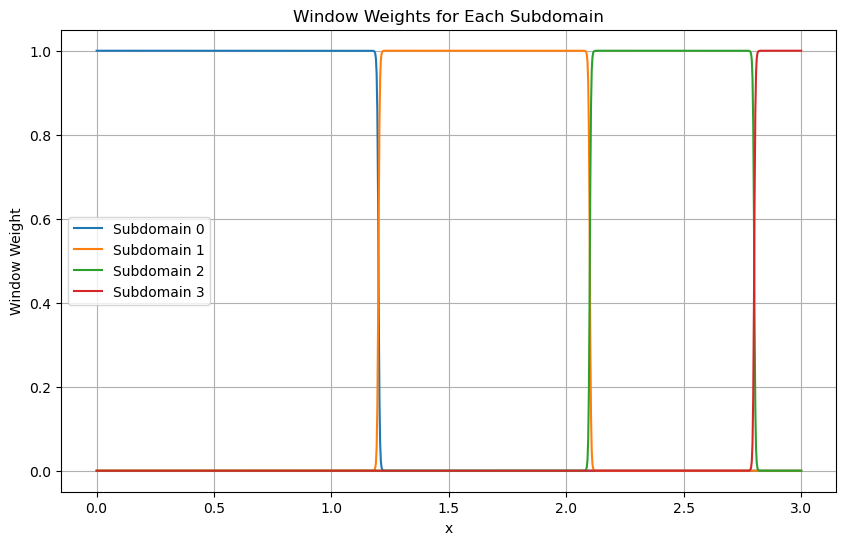

In [20]:
x_test =  jnp.linspace(0, 3, 1000).reshape(-1, 1) 
weights = my_precise_window_func(
    flat_xmins_user_defined, flat_xmaxs_user_defined, 
    wmins_user_defined, wmaxs_user_defined, 
    x_test, 
    tol=1e-8 
)

plt.figure(figsize=(10, 6))
for i in range(weights.shape[1]):
    plt.plot(x_test, weights[:, i], label=f"Subdomain {i}")
plt.xlabel('x')
plt.ylabel('Window Weight')
plt.legend()
plt.title('Window Weights for Each Subdomain')
plt.grid(True)
plt.show()

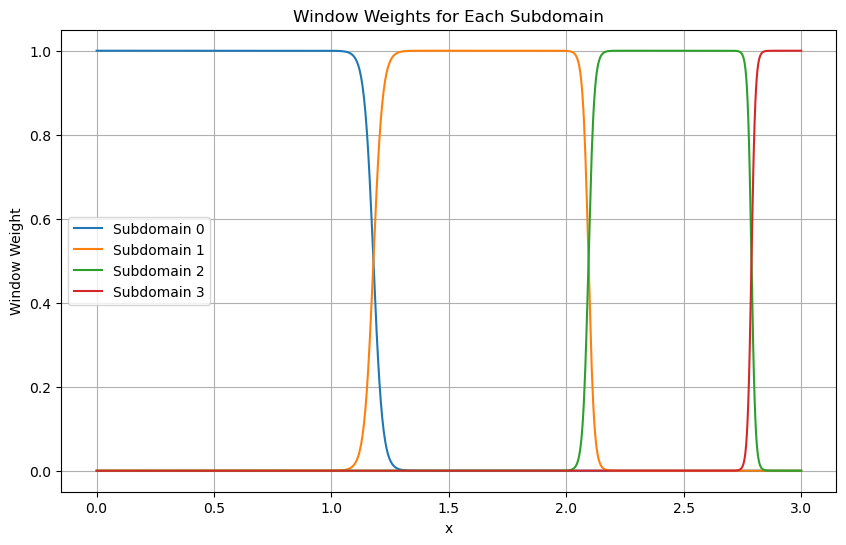

In [4]:
# According to the definition of subdomain, window function depend on the left points and right points of each subdomains
# 2 subdomains should have same widths
'''subdomain_list_not_uniform = [
    (jnp.array([-0.85]), jnp.array([0.85])), # width = 1.7 overlap = 0.1
    (jnp.array([0.75]), jnp.array([1.55])), # width =0.8 overlap = 0.1
    (jnp.array([1.45]), jnp.array([1.95])),# width = 0.5 overlap = 0.1
    (jnp.array([1.85]), jnp.array([2.15])) # width = 0.3
]'''
subdomain_list_not_uniform = [
    (jnp.array([-1.25]), jnp.array([1.25])), # width = 1.3 overlap = 0.1
    (jnp.array([1.15]), jnp.array([2.15])), # width =1.0  overlap = 0.1
    (jnp.array([2.05]), jnp.array([2.85])),# width = 0.8 overlap = 0.1
    (jnp.array([2.75]), jnp.array([3.25])) # width = 0.5
]

# illustration of window function
x_test =  jnp.linspace(0, 3, 1000).reshape(-1, 1) 
n_sub = 4
window_weights_not_uniform = my_window_func(subdomain_list_not_uniform, n_sub, x_test, tol=1e-8)
# plot
plt.figure(figsize=(10, 6))
for i in range(window_weights_not_uniform.shape[1]):
    plt.plot(x_test, window_weights_not_uniform[:, i], label=f"Subdomain {i}")
plt.xlabel('x')
plt.ylabel('Window Weight')
plt.legend()
plt.title('Window Weights for Each Subdomain')
plt.grid(True)
plt.show()

In [11]:
fixed_transition_width_val = 0.1
key = jax.random.PRNGKey(42)
model_2 = FBPINN(
    key=key,
    subdomains_tuple=subdomain_list_not_uniform,
    ansatz=ansatz,
    mlp_config=mlp_config,
    fixed_transition_width=fixed_transition_width_val # Pass the new parameter
)
subdomain_collocation_points_not_uniform, global_collocation_points_not_uniform = generate_collocation_points(
domain=domain,
subdomains_list=subdomain_list_not_uniform,
n_points_per_subdomain=n_points_per_subdomain,
seed=0
)
print(subdomain_collocation_points_not_uniform)

/tmp/ipykernel_54421/1856664297.py:3: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model_2 = FBPINN(


[Array([0.9605856 , 0.29977512, 0.816605  , ..., 0.17861009, 0.5727639 ,
       0.5399841 ], dtype=float32), Array([1.4405254, 1.583524 , 1.6605767, ..., 1.7639633, 1.4157454,
       1.8301649], dtype=float32), Array([2.3876429, 2.644216 , 2.8431783, ..., 2.7721045, 2.2909474,
       2.5847454], dtype=float32), Array([2.8431783, 2.8756714, 2.785364 , 2.7995996, 2.9048858, 2.8685403,
       2.7658474, 2.8261013, 2.842702 , 2.8614526, 2.9512558, 2.801103 ,
       2.9569516, 2.9603314, 2.9805217, 2.9004164, 2.9139872, 2.8241296,
       2.8641334, 2.9759781, 2.8318827, 2.9389162, 2.9827673, 2.7915359,
       2.9494994, 2.8576798, 2.7986646, 2.8233068, 2.9270682, 2.8816702,
       2.8964772, 2.9658494, 2.86279  , 2.9537716, 2.970389 , 2.9801345,
       2.9999614, 2.8661895, 2.9477353, 2.893075 , 2.984624 , 2.7855988,
       2.9680018, 2.8848276, 2.8803005, 2.95778  , 2.8986187, 2.7775018,
       2.8070848, 2.7786407, 2.9030566, 2.9416676, 2.8231745, 2.9613726,
       2.962782 , 2.9453495, 2

In [12]:
# train
x_test = jnp.linspace(domain[0], domain[1], 1000)
model_2, loss_hist_2, (t_steps_2, t_l1_2) = train_fbpinn(
    model=model_2,
    subdomain_collocation_points=subdomain_collocation_points_not_uniform,
    steps=steps,
    lr=lr,
    pde_residual_loss=pde_residual_loss,
    x_test=x_test,
    u_exact=u_exact,
    save_dir=None,
    checkpoint_every=0
)


FBPINN: 100%|██████████| 50000/50000 [07:56<00:00, 104.86it/s, l1=7.02e-01, loss=7.85e+03]


In [13]:
# Plot
u_pred_not_uniform = jax.vmap(model_2)(x_test).squeeze()
u_true = u_exact(x_test)


In [14]:
print("u_pred shape:", u_pred_not_uniform.shape)
print("u_true shape:", u_true.shape)


u_pred shape: (1000,)
u_true shape: (1000, 1)


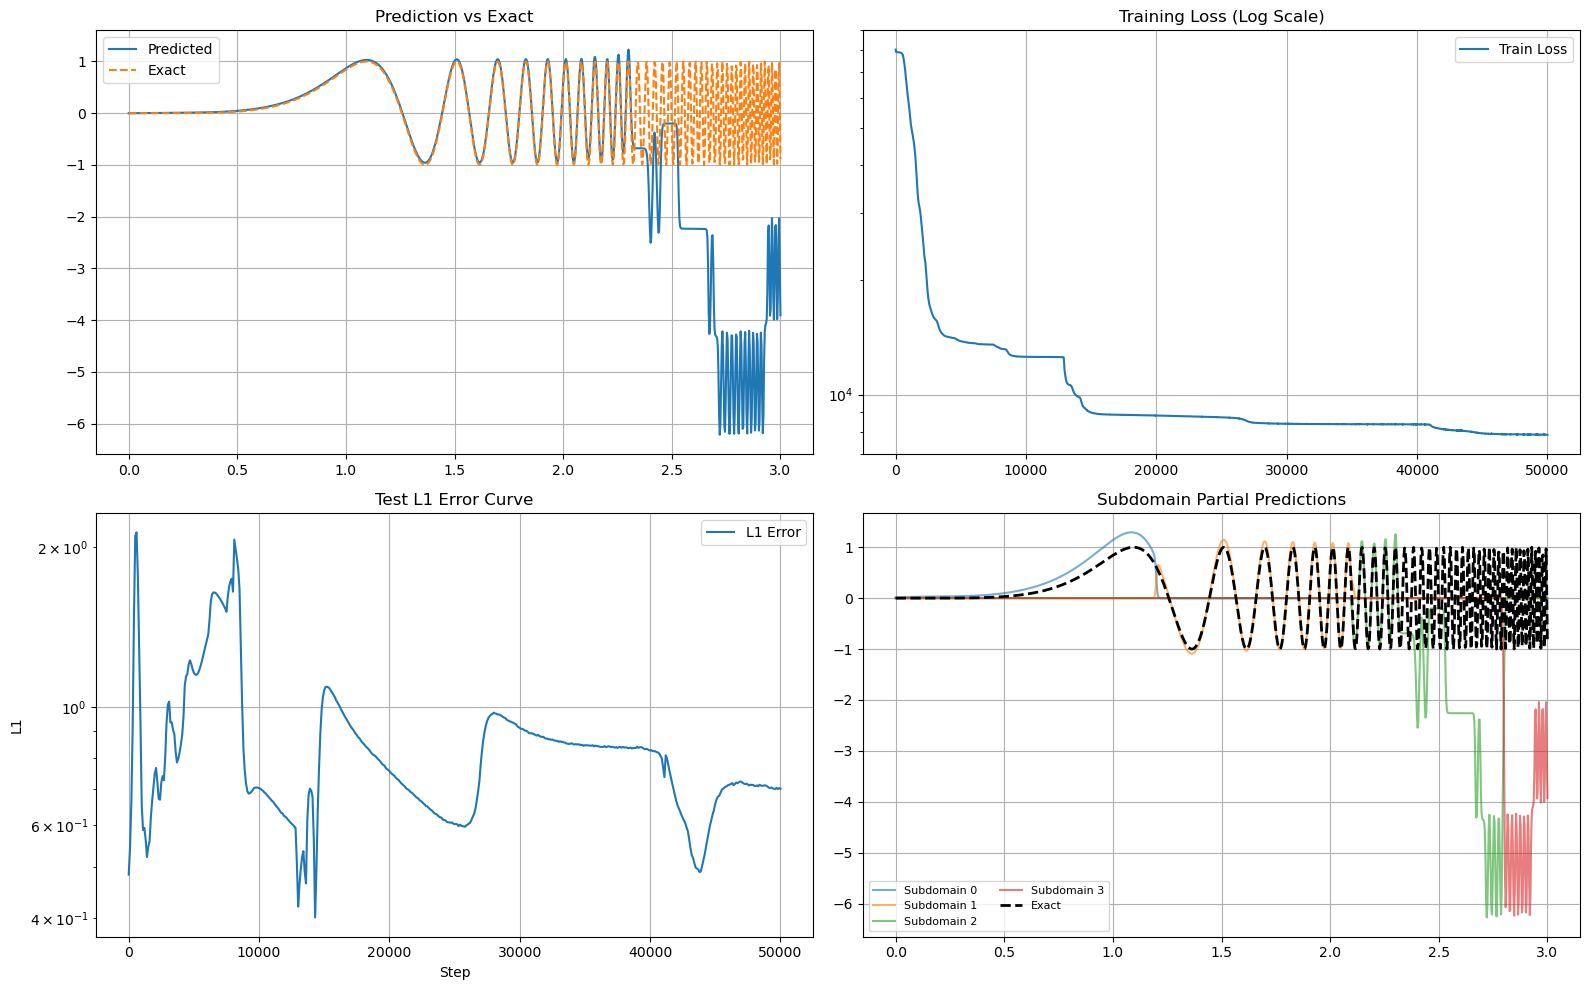

In [15]:
plot_fbpinn_summary(
    x_test=x_test,
    u_true=u_true,
    u_pred=u_pred_not_uniform,
    train_loss=loss_hist_2,
    test_steps=t_steps_2,
    test_l1=t_l1_2,
    model=model_2
)


In [ ]:
def plot_loss_and_l1_comparison(train_loss_1, train_loss_2,
                                test_steps, test_l1_1, test_l1_2,u_pred_uniform, u_pred_not_uniform, u_true,
                                label_1="Uniform", label_2="Self-defined"):
    fig, axs = plt.subplots(3, 1, figsize=(8, 10))  # 

    # Training Loss
    axs[0].plot(train_loss_1, label=label_1)
    axs[0].plot(train_loss_2, label=label_2)
    axs[0].set_title("Training Loss")
    axs[0].set_yscale("log")
    axs[0].set_xlabel("Step")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    # Test L1 Error
    axs[1].plot(test_steps, test_l1_1, label=label_1)
    axs[1].plot(test_steps, test_l1_2, label=label_2)
    axs[1].set_title("Test L1 Error")
    axs[1].set_yscale("log")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("L1 Error")
    axs[1].legend()
    axs[1].grid(True)

    # u_pred vs exact solution
    axs[2].plot(x_test, u_true, label="Exact", linewidth=1, color="black")  
    axs[2].plot(x_test, u_pred_not_uniform, '--', label="Self-defined", color="#ff7f0e")  
    axs[2].plot(x_test, u_pred_uniform, '--', label="Uniform", color="#1f77b4")
    axs[2].set_title("Prediction vs Exact Solution")
    axs[2].set_xlabel("x")
    axs[2].set_ylabel("u(x)")
    axs[2].legend()
    axs[2].grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
plot_loss_and_l1_comparison(
    train_loss_1= loss_hist,
    train_loss_2= loss_hist_2,
    test_steps= t_steps,
    test_l1_1=t_l1,
    test_l1_2=t_l1_2,
    u_pred_uniform=u_pred_uniform,
    u_pred_not_uniform=u_pred_not_uniform,
    u_true=u_true,
    label_1="Uniform",
    label_2="Self-defined"
)
